---
# Esercitazione 12
---
In questa esercitazione verranno create e utilizzate reti neurali convoluzionali e profonde per il riconoscimento di immagini; nello specifico verrà utilizzato il pacchetto Python Keras per riconoscere le $10$ cifre scritte a mano. Questo è dunque un problema di classificazione.

### Il database MNIST
Di seguito viene scaricato il dataset necessario al training della rete neurale; consiste in una serie di $70000$ immagini di cifre scritte a mano in risoluzione $28 \times 28$, in cui ogni pixel può assumere un valore intero compre tra $0$ e $255$, corrispondente alle possibili sfumature di grigio tra il bianco ($255$) e il nero ($0$). <br>
Di seguito viene utilizzato il modulo mnist che permette di scaricare i dati MNIST (modified National Institute of Standards and Technology database) delle cifre scritte a mano. Il modulo permette di scaricare i dati mantenendo sempre li stessi per training e validazione, in modo da confrontare più facilmente le performance tra modelli diversi.

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)
X_train shape: (60000, 784)
X_test shape: (10000, 784)

an example of a data point with label 4


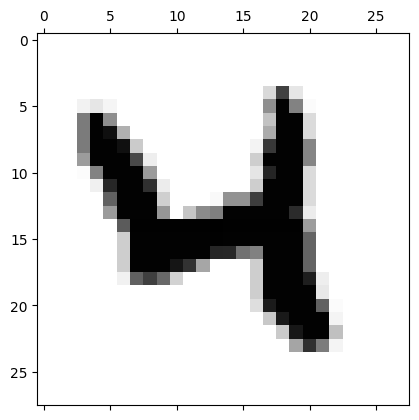

... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [2]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

# Loading data dal database mnist
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, automatic split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data() # sono le immagini e i numeri interi che identificano i numeri

# questi vettori X_train e X_test contengono la lista di 60000 e 10000 matrici; X_test[0] contiene una lista di liste, in cui quest'ultima
# è la RIGA con tutti i numeri da 0 a 255 della tonalità di grigio del rispettivo pixel


print('X_train shape:', X_train.shape) # 60000 immagini di training, 28,28
print('Y_train shape:', Y_train.shape) # 60000 NUMERI INTERI, identificano la risposta corretta dei numeri scritti

###################################################################

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

print('X_train shape:', X_train.shape)  # 60000 immagini di training, 784 (=28x28)
print('X_test shape:', X_test.shape)    # 10000 immagini di test, 784 (=28x28)
print()

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary') # per mostrare la matrice devo reimpostare la shape a quadrato 28x28
plt.show()

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
# in questo modo creo una lista di liste di 10 elementi con un 1 alla posizione che corrisponde al numero intero vero della cifra
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

####################################################################

### Costruzione della Rete Neurale Profonda
La costruzione della rete con Keras avviene in modo analogo a quanto fatto nell'esercitazione $11$. Viene creato un modello $\textit{Sequential}$ alla quale vengono aggiunti i vari strati della rete. Lo strato di input deve avere un numero di nodi pari al numero totale di pixel delle immagini ($28\times 28 = 784$ nodi); tramite il metodo "input_shape", specificato solo per il primo strato, si permette alla rete di aggiustare in automatico le dimensioni di input e output anche degli altri strati. <br>
Dopo aver scelto in modo arbitrario la dimensione e il numero di layer intermedi, lo step finale è l'aggiunta dell'ultimo layer, quello di output, che deve avere $10$ nodi ovvero uno per ogni cifra da identificare. Ogni nodo di una rete può essere pensato come una funzione che riceve in ingresso un valore numerico, svolge prodotti e somme e manda il risultato al nodo successivo attivandolo, il tutto per simulare il funzionamento di una vera rete neurale. Guardando ad esempio due layer vicini, ognuno dei neuroni del primo è collagato a tutti i neuroni del secondo. Il valore che assumerà un singolo neurone in quest'ultimo layer è detto "activation" ed è dato dal risutato di una certa funzione di attivazione (da scegliere) a cui viene dato in ingresso la somma pesata dei valori di attivazione di tutti i neuroni del layer precedente sommata a una costante detta "bias". Tutto questo viene fatto per ogni singolo neurone; ipotizzando di costruire una rete con $784$ nodi in input, $10$ in output e un layer nascosto da 20 nodi il numero totale di parametri è quindi pari a:

$$
n_{params} = ( 784 \times 20 + 20 ) + (20 \times 10 + 10) = 15910
$$

infatti ogni nodo del primo layer porta un peso per ogni nodo del secondo layer e ognuno di questi porta un bias. La prima parentesi è associata a tutti i parametri tra il primo e il secondo layer, mentre la seconda è associata al secondo e ultimo layer. Esplicitando il calcolo delle attivazioni di un singolo nodo si ha:

$$
a^{(J+1)}_k = \sigma \left( \sum_{i=1}^{n_{J}} w_{ki} \cdot a^{(J)}_i + b_k \right)
$$

dove $a^{(J+1)}_k$ è l'attivazione del nodo $k$-esimo nel layer $J+1$-esimo, la somma viene fatta su tutti gli $n_J$ nodi nel layer $J$-esimo, $w_{ki}$ è il peso relativo al collegamento tra il nodo $i$ precedente e il $k$ dello strato successivo, $b_k$ è il bias relativo al nodo dello strato successivo e, infine, $\sigma$ è la funzione di attivazione. Esempi di funzioni di attivazione sono ReLU (Rectified Linear Unit), che vale $0$ se l'ingresso è negativo, e vale l'ingresso stesso se esso è positivo, e la Sigmoide:

$$
\sigma = \dfrac{1}{1+ e^{-x}}
$$

essa permette di mappare un qualsiasi numero in un intervallo $\in [0;1]$, mappando a valori molto vicini a zero i numeri molto negativi, viceversa a $1$ i numeri molto positivi; nell'intorno di zero la sua crescita è invece circa costante. Reti neurali moderne utilizzano principalmente ReLU perché più efficiente.

Dato che il problema presente è di classificazione, la funzione di attivazione usata per lo strato di output è $\textit{softmax}$ in quanto normalizza i valori calcolati nei nodi in modo che sommino a $1$ e siano positivi, rendendo possibile interpretarli come la probabilità che quello specifico risultato sia la cifra identificata. <br>
Per ridurre l'overfitting è anche possibile specificare una frazione di $\textit{dropout}$, questa indica quanti nodi spegnere casualmente ad ogni epoca di addestramento; in questo modo si forza la rete a utilizzare altri nodi per apprendere lo stesso concetto. Un'altra tecnica che stabilizza la rete consiste nel disordinare i dati di training in input duarante tutto l'addestramento, in questo modo si evita che la rete impari erroneamente dal loro ordine specifico. <br>
Lo step successivo è settare una funzione di perdita da minimizzare durante l'addestramento. Per i problemi di classificazione una scelta della loss function è la "categorical_crossentropy". Durante l'addestramento, il modello cerca di regolare tutti i pesi e i bias di ogni nodo per minimizzare la funzione di perdita. Qui vengono ottimizzati con l'optimizer $\textit{SGD}$, ovvero Discesa Stocastica del Gradiente. Questo metodo consiste nel calcolare il gradiente della funzione costo (per le reti neurali attraverso la tecnica del Backpropagation) e procedere a piccoli step in direzione della decrescita massima, poi reiterando il processo. Viene aggiunta una componente di randomicità in modo da velocizzare la discesa verso il minimo locale della funzione (sperabilemente assoluto). <br>
Per stabilizzare la rete e per far sì che l'ottimizzatore SGD lavori in modo più efficiente, i dati di training sono divisi in batches. Questa tecnica permette una convergenza più veloce e maggiore efficienza computazionale, dato che si lavora con una mole di dati inferiore. Nello specifico, se il numero di dati per batch è $n_{batch}$, ogni epoca analizza tutti i dati di training ma a blocchi di $n_{batch}$ elementi, aggiornando il valore dei pesi alla fine di ogni blocco di dati. <br>

Per testare la bontà del modello nel riconoscere le immagini viene utilizzata la metrica $\textit{accuracy}$ che fornisce la percentuale di classificazioni corrette dei dati.<br>
Una volta completata la fase di training si valuta il modello ottenuto dopo l'addestramento sui dati di validazione, calcolando la funzione costo e l'accurancy. A questo punto tutti i parametri della rete sono fissati dalla fase di addestramento, quindi in realtà la rete neurale non sa realmente riconoscere le cifre, ciò si nota meglio dando in ingresso una griglia casuale: la rete "riconoscerà" comunque una delle $10$ cifre, infatti non è addestrata a non rispondere.

Di seguito viene implementato quanto descritto.

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    # Aggiungo l'input layer con 28x28 nodi e il primo nascosto con 400 nodi
    model.add(Dense(400, input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    # Aggiungo un layer nascosto da 100 nodi
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5)) # spegne il 50% dei nodi a caso ad ogni epoca per ridurre overfitting
    # soft-max layer per normalizzare a 1 la somma delle uscite e renderle ognuna positiva
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# print('Model architecture created successfully!')

def compile_model():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['acc']) # scelgo la metrica accuracy per valutare la bontà delle previsioni (quante sono corrette)
    return model


c:\Users\teote\Desktop\uni\2023-2024\Lab_Simulazione_Numerica\venv_dir\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - acc: 0.6367 - loss: 1.1771 - val_acc: 0.9149 - val_loss: 0.3142
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - acc: 0.8830 - loss: 0.4101 - val_acc: 0.9331 - val_loss: 0.2386
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - acc: 0.9104 - loss: 0.3198 - val_acc: 0.9426 - val_loss: 0.1990
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - acc: 0.9222 - loss: 0.2717 - val_acc: 0.9489 - val_loss: 0.1748
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - acc: 0.9320 - loss: 0.2390 - val_acc: 0.9533 - val_loss: 0.1567
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9446 - loss: 0.1837

Test loss: 0.15673410892486572
Test accuracy: 0.9532999992370605


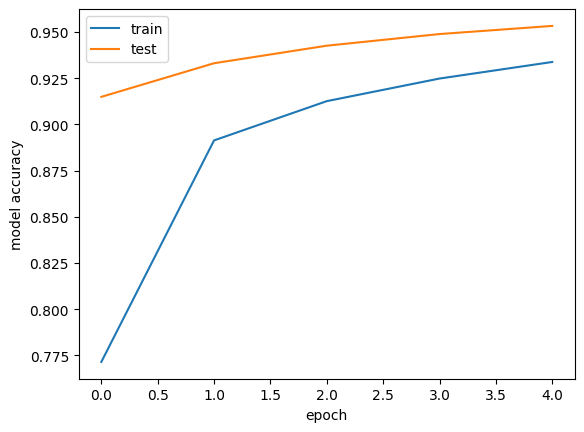

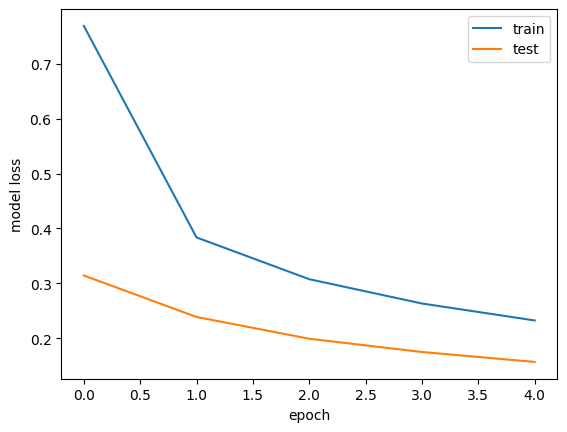

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


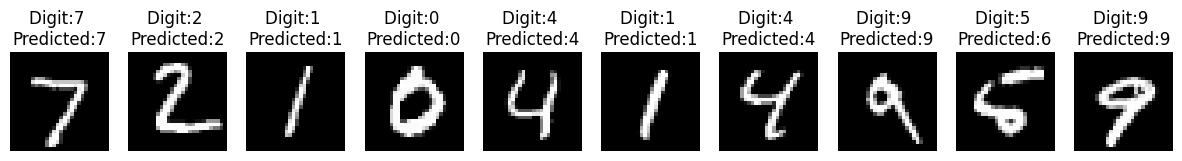

In [3]:
# print('Model compiled successfully and ready to be trained.')

# Train the Model: training parameters
batch_size = 32
epochs = 5 # aumentare almeno a 50

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train, # input e output (quello vero con cui confrontare)
                        batch_size=batch_size, # divisione del dataset di training
                        epochs=epochs,
                        verbose=1, # ovvero stampa runtime il progresso dell'addestramento
                        validation_data=(X_test, Y_test))

# Test del modello addestrato sui dati di validazione
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

# print(X_test[0])
# print("Reshaping")

# prima di fare il reshape X_test contiene tutte le matrici 28x28
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1) # lista di 28 liste con dentro 28 numeri (ognuno è una lista da un elemento)
# print(X_test[0])

plt.figure(figsize=(15, 15))
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit:{} \nPredicted:{}".format(np.argmax(Y_test[i]), np.argmax(predictions[i]))) # argmax ritorna l'indice del valore massimo in un array
    plt.axis('off') 
plt.show()

Come è possibile notare, il modello implementato permette un'accurancy coi dati di validazione del $95.33\%$ nel riconoscere le cifre, l'obiettivo sarà dunque migliorare questo risultato.

### Esercizio 12.1
In questo primo punto viene testata la rete al variare del numero di epoche, fissando l'ottimizzatore a SGD. Verrà mostrato l'andamento per $5,15,25,35$ epoche.

In [33]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
# Loading data dal database mnist
from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, automatic split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
# sono le immagini e i numeri interi che identificano le digits corrette

# questi vettori X_train e X_test contengono la lista di 60000 e 10000 matrici 28x28; 
# X_test[0] contiene una lista di liste, in cui quest'ultima è la RIGA con tutti i numeri da 0 a 255 
# della tonalità di grigio del rispettivo pixel

###################################################################
# reshape data, it could depend on Keras backend, serve perché Dense si aspetta in ingresso vettori 1D non 2D
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols) # 60000 immagini di training, 784 (risultato di 28x28)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols) # 10000 immagini di test, 784 (risultato di 28x28)

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
# in questo modo creo una lista di liste di 10 elementi con un 1 alla posizione che corrisponde al numero intero vero della cifra
Y_test = keras.utils.to_categorical(Y_test, num_classes)

####################################################################
def create_DNN(neurons_per_layers:list):
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    # Aggiungo l'input layer con 28x28 nodi
    model.add(Input(shape=(img_rows*img_cols,)))  # Aggiungi l'input layer
    # Aggiungo i layers nascosti
    for n in neurons_per_layers:
        model.add(Dense(n, activation='relu'))

    # apply dropout with rate 0.5
    model.add(Dropout(0.5)) # spegne il 50% dei nodi a caso ad ogni epoca per ridurre overfitting
    # soft-max layer output per normalizzare a 1 la somma delle uscite e renderle ognuna positiva
    model.add(Dense(num_classes, activation='softmax'))
    
    return model


def compile_model(optimizer, loss, neurons_per_layer:list):
    # create the model
    model=create_DNN(neurons_per_layers=neurons_per_layer)
    # compile the model
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['acc']) # scelgo la metrica accuracy per valutare la bontà delle previsioni (quante sono corrette)
    return model


def draw_graphs(epochs, loss=keras.losses.categorical_crossentropy, optimizer='sgd', batch_size=32, verbose=1, neurons_per_layer=[400,100]):
    # create the deep neural net
    model_DNN = compile_model(optimizer, loss, neurons_per_layer=neurons_per_layer)

    # train DNN and store training info in history
    history = model_DNN.fit(X_train, Y_train, # input e output (quello vero con cui confrontare)
                            batch_size=batch_size, # divisione del dataset di training
                            epochs=epochs,
                            verbose=verbose, # ovvero stampa runtime il progresso dell'addestramento
                            validation_data=(X_test, Y_test))

    # Test del modello addestrato sui dati di validazione
    score = model_DNN.evaluate(X_test, Y_test, verbose=verbose)

    # print performance
    print()
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # look into training history, summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(optimizer + ' optimizer and ' + loss + ' loss function' if loss != keras.losses.categorical_crossentropy else 'Results using ' + optimizer + ' optimizer and cat. cross entropy loss function')
    plt.ylabel('model accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(optimizer + ' optimizer and ' + loss + ' loss function' if loss != keras.losses.categorical_crossentropy else 'Results using ' + optimizer + ' optimizer and cat. cross entropy loss function')
    plt.ylabel('model loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

    predictions = model_DNN.predict(X_test)

    # per disegnare ho bisogno di riconvertire in matrici 28x28
    X_test_reshaped = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1) # lista di 28 liste con dentro 28 numeri (ognuno è una lista da un elemento)

    plt.figure(figsize=(15, 15))
    for i in range(10):    
        ax = plt.subplot(2, 10, i + 1)    
        plt.imshow(X_test_reshaped[i, :, :, 0], cmap='gray')    
        plt.title("Digit:{} \nPredicted:{}".format(np.argmax(Y_test[i]), np.argmax(predictions[i]))) # argmax ritorna l'indice del valore massimo in un array
        plt.axis('off') 
    plt.show()

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - acc: 0.6464 - loss: 1.1580 - val_acc: 0.9131 - val_loss: 0.3115
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - acc: 0.8841 - loss: 0.4099 - val_acc: 0.9311 - val_loss: 0.2401
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - acc: 0.9097 - loss: 0.3227 - val_acc: 0.9412 - val_loss: 0.2017
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - acc: 0.9225 - loss: 0.2752 - val_acc: 0.9466 - val_loss: 0.1762
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - acc: 0.9314 - loss: 0.2433 - val_acc: 0.9508 - val_loss: 0.1593
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9417 - loss: 0.1863

Test loss: 0.15934643149375916
Test accuracy: 0.9508000016212463


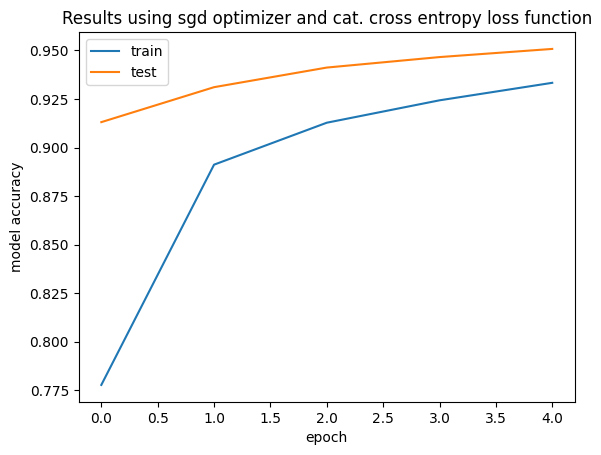

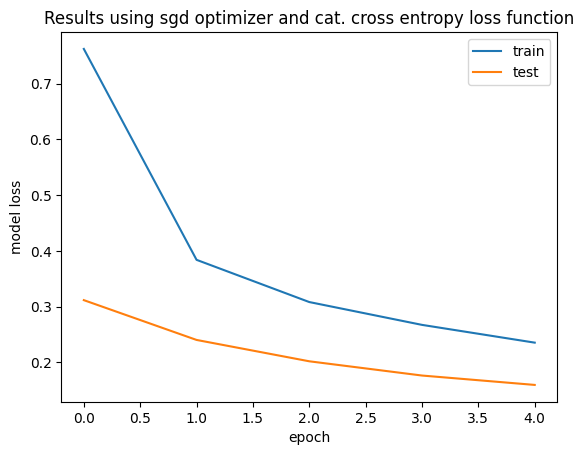

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


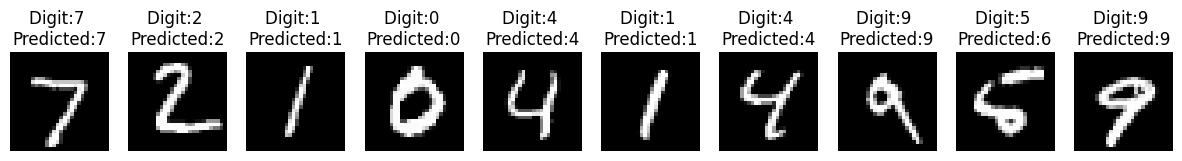

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.6417 - loss: 1.1680 - val_acc: 0.9147 - val_loss: 0.3066
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - acc: 0.8857 - loss: 0.4007 - val_acc: 0.9306 - val_loss: 0.2362
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - acc: 0.9113 - loss: 0.3209 - val_acc: 0.9409 - val_loss: 0.2017
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - acc: 0.9222 - loss: 0.2763 - val_acc: 0.9465 - val_loss: 0.1784
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - acc: 0.9322 - loss: 0.2430 - val_acc: 0.9523 - val_loss: 0.1586
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - acc: 0.9395 - loss: 0.2164 - val_acc: 0.9560 - val_loss: 0.1428
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - acc: 0.9435 - loss: 0.2003 - val_acc: 0.9591 - val_loss: 0.1331
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - acc: 0.9486 - loss: 0.1832 - val_acc: 0.9606 - val_loss: 0.1248
Epoch 9/15
1875/1875 ━━━━━━━━━━━━━━━━

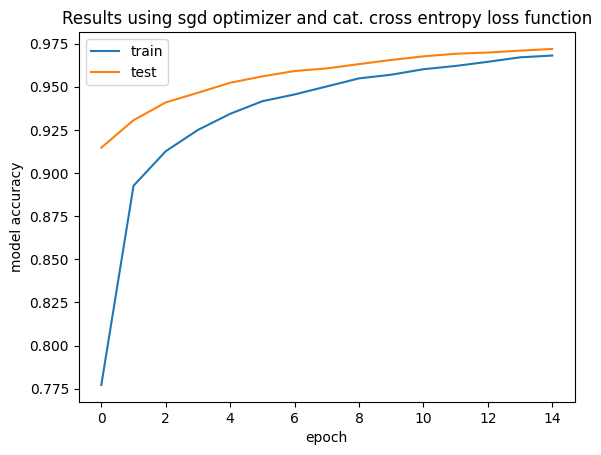

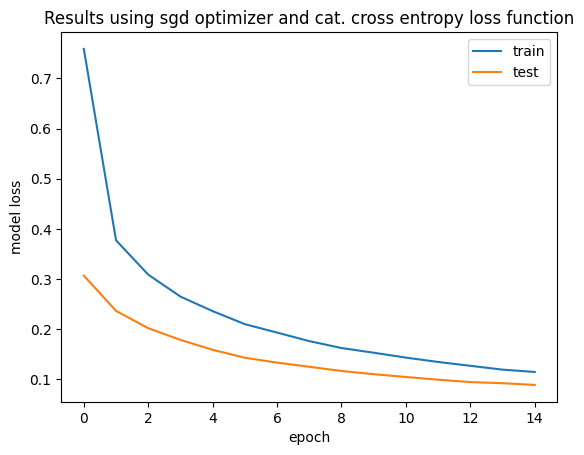

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


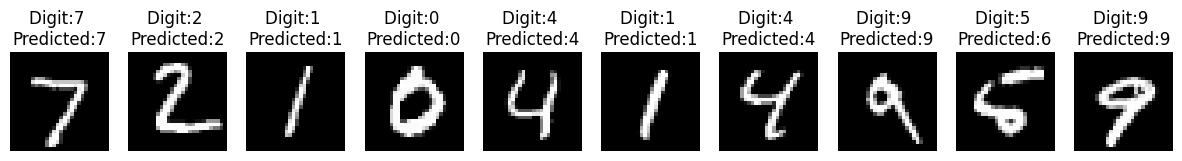

Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - acc: 0.6349 - loss: 1.1908 - val_acc: 0.9140 - val_loss: 0.3198
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - acc: 0.8818 - loss: 0.4222 - val_acc: 0.9285 - val_loss: 0.2455
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - acc: 0.9062 - loss: 0.3302 - val_acc: 0.9403 - val_loss: 0.2026
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - acc: 0.9210 - loss: 0.2777 - val_acc: 0.9477 - val_loss: 0.1776
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - acc: 0.9323 - loss: 0.2449 - val_acc: 0.9523 - val_loss: 0.1614
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - acc: 0.9394 - loss: 0.2206 - val_acc: 0.9555 - val_loss: 0.1470
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - acc: 0.9444 - loss: 0.1989 - val_acc: 0.9589 - val_loss: 0.1341
Epoch 8/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - acc: 0.9496 - loss: 0.1822 - val_acc: 0.9614 - val_loss: 0.1250
Epoch 9/25
1875/1875 ━━━━━━━━━━━━━━━━━━

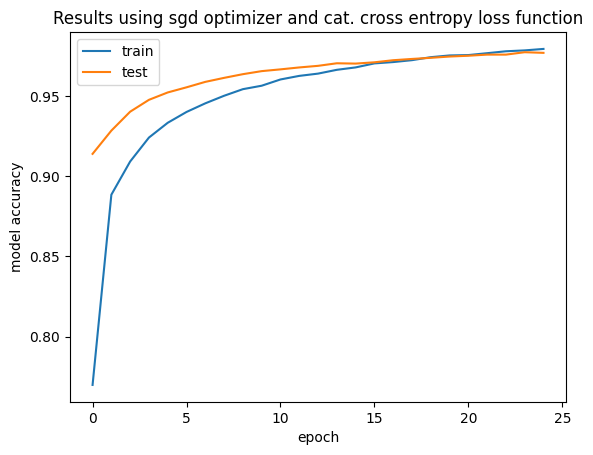

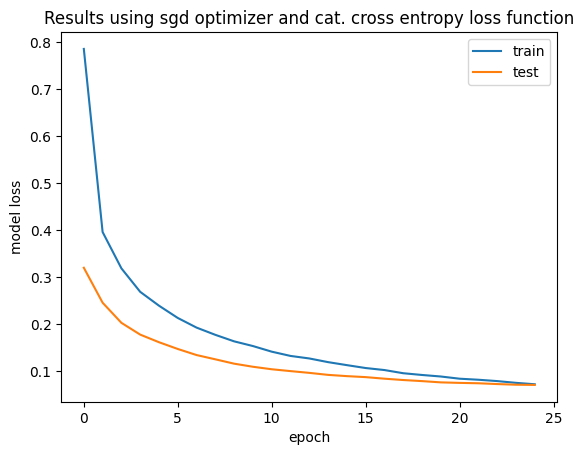

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


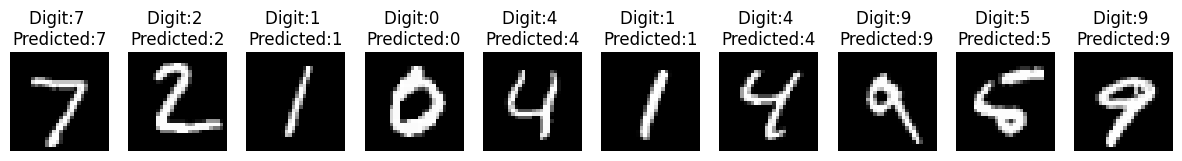

Epoch 1/35
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - acc: 0.6404 - loss: 1.1550 - val_acc: 0.9116 - val_loss: 0.3165
Epoch 2/35
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - acc: 0.8831 - loss: 0.4096 - val_acc: 0.9287 - val_loss: 0.2435
Epoch 3/35
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - acc: 0.9099 - loss: 0.3266 - val_acc: 0.9381 - val_loss: 0.2085
Epoch 4/35
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - acc: 0.9227 - loss: 0.2803 - val_acc: 0.9450 - val_loss: 0.1836
Epoch 5/35
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - acc: 0.9313 - loss: 0.2432 - val_acc: 0.9508 - val_loss: 0.1635
Epoch 6/35
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - acc: 0.9384 - loss: 0.2190 - val_acc: 0.9540 - val_loss: 0.1483
Epoch 7/35
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - acc: 0.9429 - loss: 0.1995 - val_acc: 0.9583 - val_loss: 0.1378
Epoch 8/35
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - acc: 0.9488 - loss: 0.1815 - val_acc: 0.9605 - val_loss: 0.1263
Epoch 9/35
1875/1875 ━━━━━━━━━━━━━━━━━━━

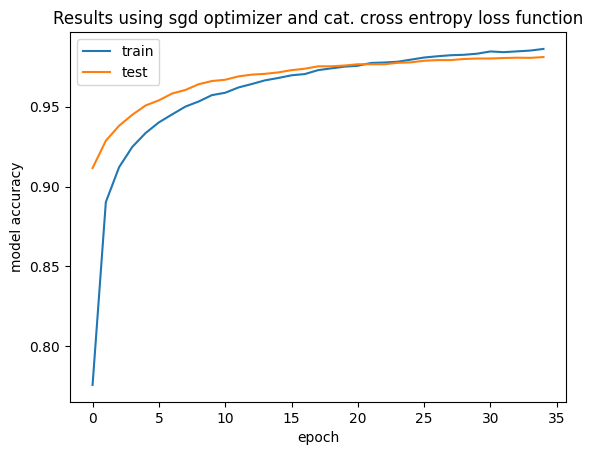

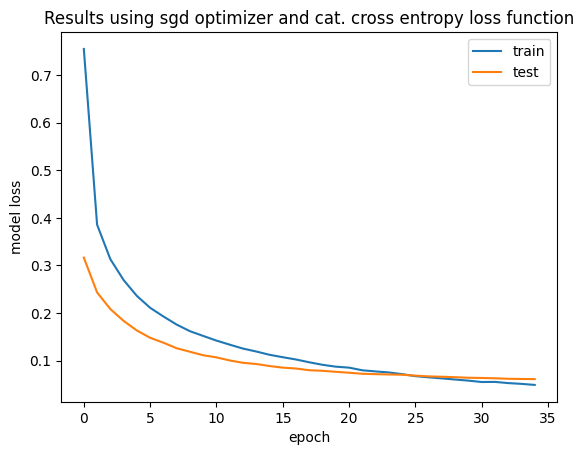

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


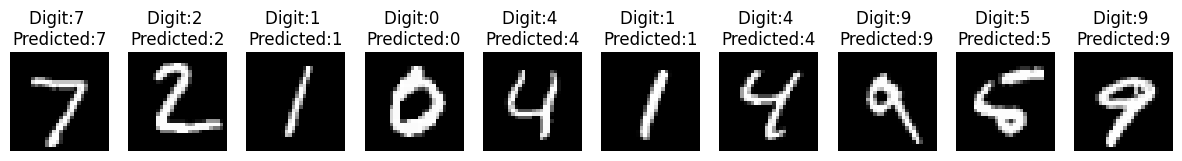

In [34]:
# definisco la lista di epoche da testare, uso i valori di ottimizzatore e loss function di default (sgd e cat. cross entropy)
epochs_list = [5, 15, 25, 35]

for ep in epochs_list:
    draw_graphs(epochs=ep, verbose=1) # lascio i due hidden layer di default, 400 e 100 neuroni


Come è possibile notare, vi è un comportamento strano per un numero troppo basso di epoche (diciamo $20$): la loss function dei dati di validazione è più bassa di quella dei dati di training! Questo risultato potrebbe essere dovuto al fatto che durante il training è attiva la funzione di Dropout, che spegne alcuni neuroni, mentre durante la validazione no. <br>
Notiamo anche che per un alto numero di epoche l'eccettazione e la loss function dei dati di training migliorano, si mantengono però pressoché invariati quelli dei dati di validazione. Al variare del numero di epoche, infatti, si può verificare che il decremento percentuale più grande dell'accuracy tra un valore e il successivo si è ottenuto passando da $5$ a $15$ epoche, ovvero $-2.22\%$; da $15$ a $25$ epoche il decremento è stato $-0.52\%$ mentre da $25$ a $35$ è diminuita di $-0.42\%$. Data la leggera diminuzione dell'accurancy a discapito di un elevato incremento di epoche (e quindi computational effort) si sceglie di fissare questo numero a $20$.

Di seguito vengono mostrati i risultati al variare dell'ottimizzatore, testando SGD, AdaDelta, AdaMax e NAdam.

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.6259 - loss: 1.2253 - val_acc: 0.9123 - val_loss: 0.3247
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.8797 - loss: 0.4247 - val_acc: 0.9318 - val_loss: 0.2460
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - acc: 0.9057 - loss: 0.3367 - val_acc: 0.9403 - val_loss: 0.2076
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - acc: 0.9203 - loss: 0.2839 - val_acc: 0.9461 - val_loss: 0.1824
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - acc: 0.9296 - loss: 0.2502 - val_acc: 0.9511 - val_loss: 0.1636
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.9358 - loss: 0.2245 - val_acc: 0.9555 - val_loss: 0.1484
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.9426 - loss: 0.2058 - val_acc: 0.9588 - val_loss: 0.1366
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - acc: 0.9475 - loss: 0.1866 - val_acc: 0.9594 - val_loss: 0.1281
Epoch 9/20
1875/1875 ━━━━━━━━━━━

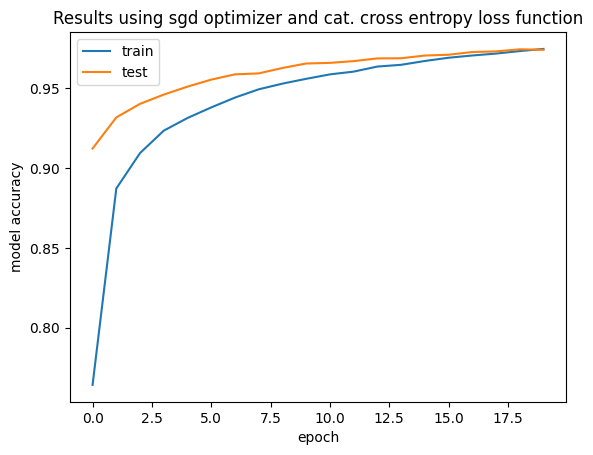

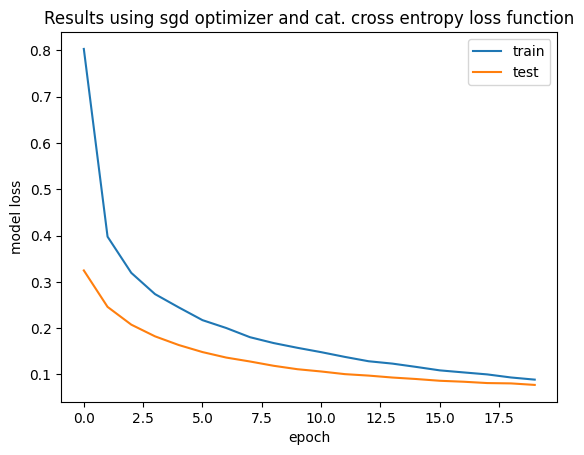

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


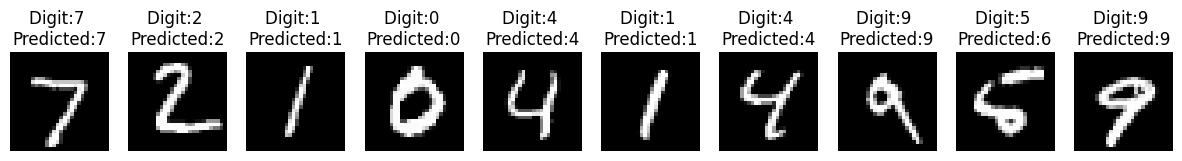

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - acc: 0.1309 - loss: 2.3033 - val_acc: 0.3118 - val_loss: 2.1100
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - acc: 0.2531 - loss: 2.1164 - val_acc: 0.5112 - val_loss: 1.9408
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - acc: 0.3667 - loss: 1.9640 - val_acc: 0.6075 - val_loss: 1.7757
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - acc: 0.4618 - loss: 1.8130 - val_acc: 0.6678 - val_loss: 1.6143
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - acc: 0.5242 - loss: 1.6698 - val_acc: 0.7162 - val_loss: 1.4620
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - acc: 0.5696 - loss: 1.5418 - val_acc: 0.7486 - val_loss: 1.3253
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - acc: 0.6070 - loss: 1.4247 - val_acc: 0.7713 - val_loss: 1.2059
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - acc: 0.6378 - loss: 1.3228 - val_acc: 0.7935 - val_loss: 1.1029
Epoch 9/20
1875/1875 ━━━━━━

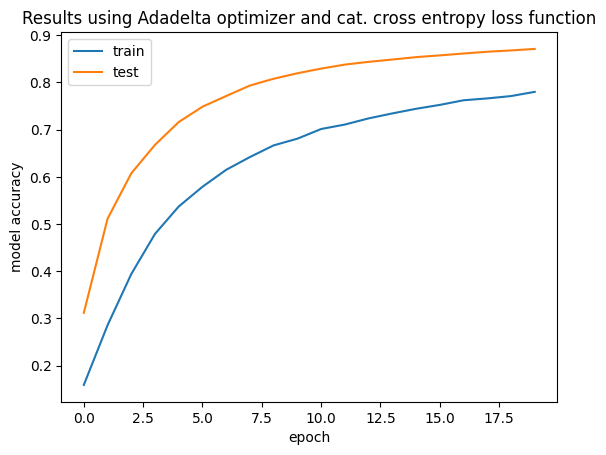

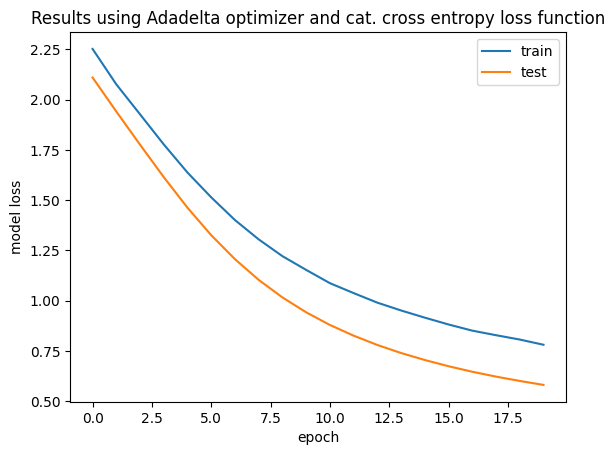

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


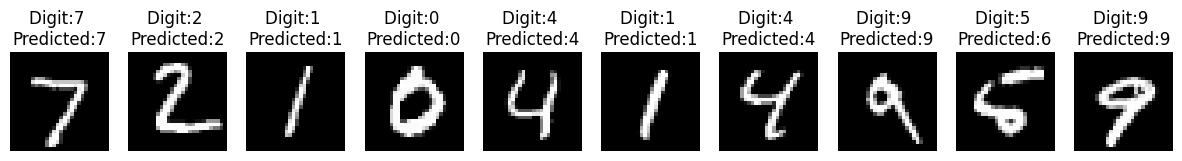

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - acc: 0.8092 - loss: 0.6408 - val_acc: 0.9487 - val_loss: 0.1666
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - acc: 0.9380 - loss: 0.2184 - val_acc: 0.9620 - val_loss: 0.1200
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - acc: 0.9561 - loss: 0.1570 - val_acc: 0.9683 - val_loss: 0.1006
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - acc: 0.9658 - loss: 0.1258 - val_acc: 0.9719 - val_loss: 0.0884
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - acc: 0.9702 - loss: 0.1074 - val_acc: 0.9751 - val_loss: 0.0796
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - acc: 0.9746 - loss: 0.0907 - val_acc: 0.9760 - val_loss: 0.0771
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - acc: 0.9780 - loss: 0.0793 - val_acc: 0.9782 - val_loss: 0.0705
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - acc: 0.9812 - loss: 0.0669 - val_acc: 0.9793 - val_loss: 0.0690
Epoch 9/20
1875/1875 ━━━━━━

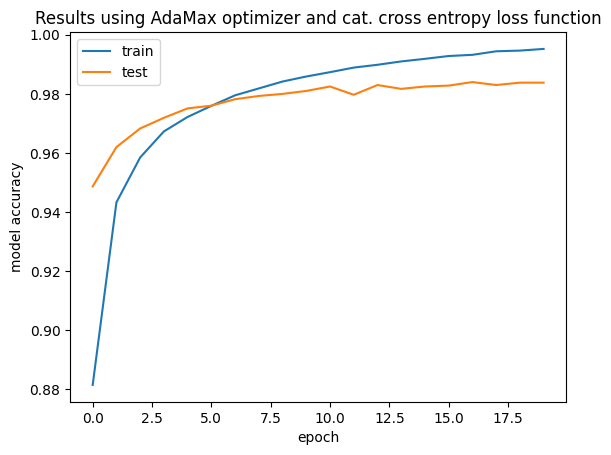

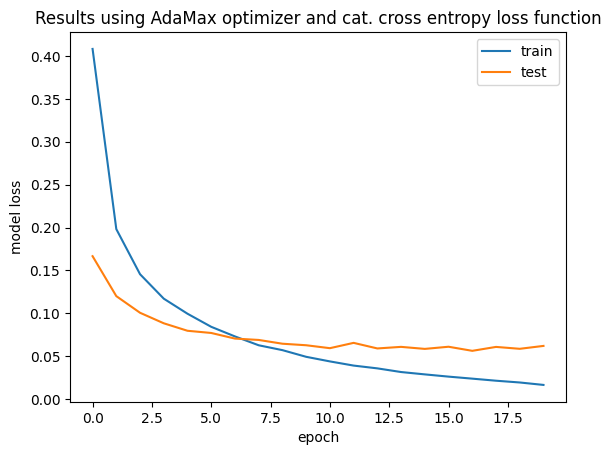

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


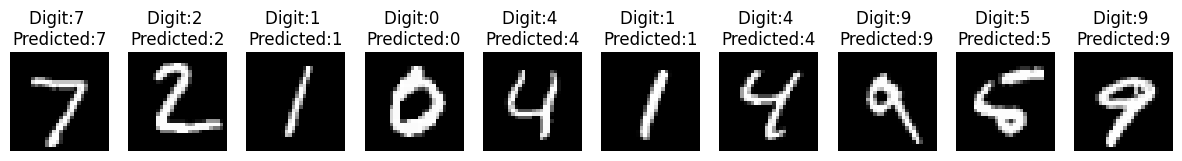

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - acc: 0.8602 - loss: 0.4646 - val_acc: 0.9632 - val_loss: 0.1144
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - acc: 0.9614 - loss: 0.1397 - val_acc: 0.9742 - val_loss: 0.0842
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - acc: 0.9728 - loss: 0.0934 - val_acc: 0.9762 - val_loss: 0.0823
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - acc: 0.9799 - loss: 0.0684 - val_acc: 0.9763 - val_loss: 0.0815
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - acc: 0.9826 - loss: 0.0554 - val_acc: 0.9796 - val_loss: 0.0841
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - acc: 0.9855 - loss: 0.0479 - val_acc: 0.9767 - val_loss: 0.1003
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - acc: 0.9877 - loss: 0.0412 - val_acc: 0.9757 - val_loss: 0.0957
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - acc: 0.9890 - loss: 0.0378 - val_acc: 0.9806 - val_loss: 0.0794
Epoch 9/20
1875/1875 ━━━

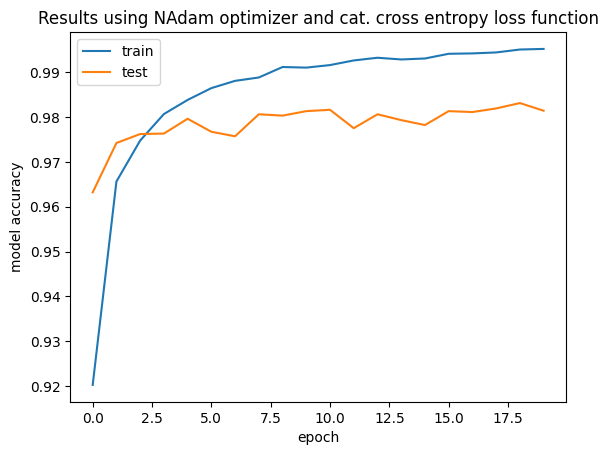

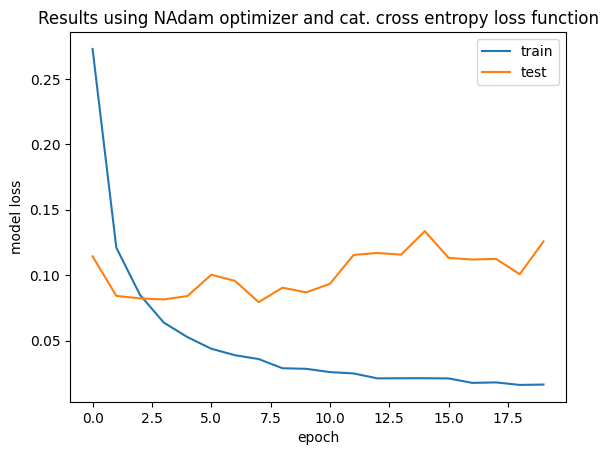

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


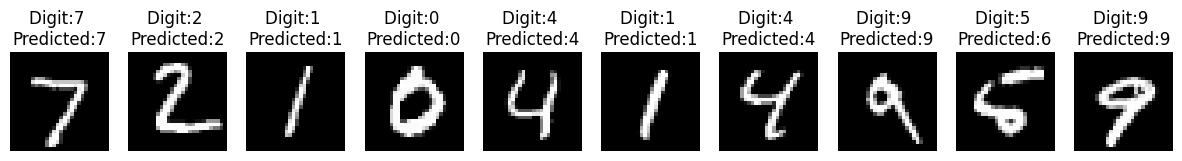

In [36]:
# fisso le epoche
n_epochs = 20
# definisco la lista di ottimizzatori
optimizer_list = ['sgd','Adadelta','AdaMax','NAdam']

for op in optimizer_list:
    draw_graphs(epochs=n_epochs, optimizer=op, verbose=1) # lascio i due hidden layer di default, 400 e 100 neuroni


Di seguito vengono trascritti i risultati ottenuti con i vari ottimizzatori, utilizzando $20$ epoche:

$$
\begin{array}{|c|c|c|}
    \hline
    \text{Optimizer} & \text{Test loss} & \text{Test accuracy} \\
    \hline
    \text{SGD} & \text{0.07749} & \text{0.97420} \\
    \hline
    \text{AdaDelta} & \text{0.58032} & \text{0.87110} \\
    \hline
    \text{AdaMax} & \text{0.06200} & \text{0.98379} \\
    \hline
    \text{NAdam} & \text{0.12579} & \text{0.98140} \\
    \hline
\end{array}
$$

Da questi risultati si evince che l'ottimizzatore migliore è AdaMax, e guardando l'andamento della loss function si nota che bastano $10$ epoche.

### Esercizio 12.2
In questo secondo punto viene modificata la rete neurale profonda aggiungendo due layer convoluzionali: Conv2d e MaxPooling2D. I layer convoluzionali "scannerizzano" la griglia di neuroni in ingresso (ad esempio l'immagine di pixel se è il layer di input) e analizzano gruppi di pixel per poi estrarre un singolo valore in uscita da ognuno. Con questa analisi è possibile addestrare la rete a riconoscere pattern come invarianza traslazionale e correlazioni presenti tra pixel vicini di una cifra scritta. Il layer convoluzionale MaxPooling2D, per come verrà implementato, scannerizza tutta una rete a blocchi di nodi $2 \times 2$, restituendo come singolo valore il numero massimo tra le $4$ attivazioni. <br>
Di seguito vengono mostrati i risultati della rete con la configurazione migliore trovata in precedenza (ottimizzatore AdaMax e 10 epoche) con l'aggiunta di un layer convoluzionale Conv2D seguito da un MaxPooling2D con analisi a $2 \times 2$ valori. Gli ultimi due layer sono di tipo Dense e dato che il MaxPooling riduce la dimensione dei neuroni da $20 \times 28$ a $14 \times 14$, vengono aggiunti di dimensione $100$ e $25$, ovvero un quarto della dimensioni dei layer nella DNN precedente (è una prova che mantiene lo stesso rapporto tra numero di valori in ingresso e in uscita nei layer Dense rispetto a quanto fatto nell'esercizio precedente).

(Il codice è stato leggermente modificato)

In [1]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
# Loading data dal database mnist
from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.layers import Flatten, Conv2D, MaxPooling2D

seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, automatic split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
# sono le immagini e i numeri interi che identificano le digits corrette

# questi vettori X_train e X_test contengono la lista di 60000 e 10000 matrici 28x28; 
# X_test[0] contiene una lista di liste, in cui quest'ultima è la RIGA con tutti i numeri da 0 a 255 
# della tonalità di grigio del rispettivo pixel

# In una rete convoluzionale devo lasciare i dati come matrici 2D
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols) # 1 indica che c'è un solo canale di colore
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
# in questo modo creo una lista di liste di 10 elementi con un 1 alla posizione che corrisponde al numero intero vero della cifra
Y_test = keras.utils.to_categorical(Y_test, num_classes)

####################################################################
def create_CNN(optimizer, loss, neurons_per_layer:list):
    "Create a Convolutional Neural Network"
    # instantiate model
    model = Sequential()
    # Nella DCNN prima di un convolutional layer l'input layer 1D con 28x28 nodi non va messo
    # model.add(Input(shape=(img_rows*img_cols,)))
    
    # Aggiungo il primo layer convoluzionale fatto da 10 filtri 5x5 (ovvero analizzano gruppi di pixel 5x5)
    model.add(Conv2D(10, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    # aggiungo un layer che riduce a 14x14 i pixel (prende il massimo tra i 4 pixel presi in considerazione)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5)) # spegne il 50% dei nodi a caso ad ogni epoca per ridurre overfitting

    # reshape dei dati ad array 1D
    model.add(Flatten())

    # Aggiungo i layers nascosti, se i neuroni per layers inseriti in ingresso sono [0] allora non aggiungo niente
    # devo mettere il controllo altrimenti fa casino
    if neurons_per_layer[0]==0 and len(neurons_per_layer)==1:
        pass
    else:
        for n in neurons_per_layer:
            model.add(Dense(n, activation='relu'))
            # apply dropout with rate 0.5
            model.add(Dropout(0.5)) # spegne il 50% dei nodi a caso ad ogni epoca per ridurre overfitting
            
    # soft-max layer output per normalizzare a 1 la somma delle uscite e renderle ognuna positiva
    model.add(Dense(num_classes, activation='softmax'))

    # compile the model
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['acc']) # scelgo la metrica accuracy per valutare la bontà delle previsioni (quante sono corrette)

    return model


def draw_graphs(epochs, loss=keras.losses.categorical_crossentropy, optimizer='sgd', batch_size=32, verbose=1, neurons_per_layer=[400,100]):
    # create the deep neural net
    model_CNN = create_CNN(optimizer, loss, neurons_per_layer=neurons_per_layer)

    # train DNN and store training info in history
    history = model_CNN.fit(X_train, Y_train, # input e output (quello vero con cui confrontare)
                            batch_size=batch_size, # divisione del dataset di training
                            epochs=epochs,
                            verbose=verbose, # ovvero stampa runtime il progresso dell'addestramento
                            validation_data=(X_test, Y_test))

    # Test del modello addestrato sui dati di validazione
    score = model_CNN.evaluate(X_test, Y_test, verbose=verbose)

    # print performance
    print()
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # look into training history, summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('CNN with ' + optimizer + ' optimizer and ' + loss + ' loss function' if loss != keras.losses.categorical_crossentropy else 'Results using ' + optimizer + ' optimizer and cat. cross entropy loss function')
    plt.ylabel('model accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('CNN with ' + optimizer + ' optimizer and ' + loss + ' loss function' if loss != keras.losses.categorical_crossentropy else 'Results using ' + optimizer + ' optimizer and cat. cross entropy loss function')
    plt.ylabel('model loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

    predictions = model_CNN.predict(X_test)

    # per disegnare ho bisogno di riconvertire in matrici 28x28
    X_test_reshaped = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1) # lista di 28 liste con dentro 28 numeri (ognuno è una lista da un elemento)

    plt.figure(figsize=(15, 15))
    for i in range(10):    
        ax = plt.subplot(2, 10, i + 1)    
        plt.imshow(X_test_reshaped[i, :, :, 0], cmap='gray')    
        plt.title("Digit:{} \nPredicted:{}".format(np.argmax(Y_test[i]), np.argmax(predictions[i]))) # argmax ritorna l'indice del valore massimo in un array
        plt.axis('off') 
    plt.show()

c:\Users\teote\Desktop\uni\2023-2024\Lab_Simulazione_Numerica\File_Esercizi\LSN_venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - acc: 0.4090 - loss: 1.6846 - val_acc: 0.9183 - val_loss: 0.4029
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - acc: 0.7222 - loss: 0.8586 - val_acc: 0.9413 - val_loss: 0.2539
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - acc: 0.7956 - loss: 0.6638 - val_acc: 0.9526 - val_loss: 0.1937
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.8359 - loss: 0.5580 - val_acc: 0.9581 - val_loss: 0.1639
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.8562 - loss: 0.4890 - val_acc: 0.9613 - val_loss: 0.1403
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.8724 - loss: 0.4455 - val_acc: 0.9655 - val_loss: 0.1265
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - acc: 0.8832 - loss: 0.4115 - val_acc: 0.9688 - val_loss: 0.1128
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - acc: 0.8914 - loss: 0.3900 - val_acc: 0.9717 - val_loss: 0.1042
Epoch 9/10
1875/1875 ━━━━━━━━━━━

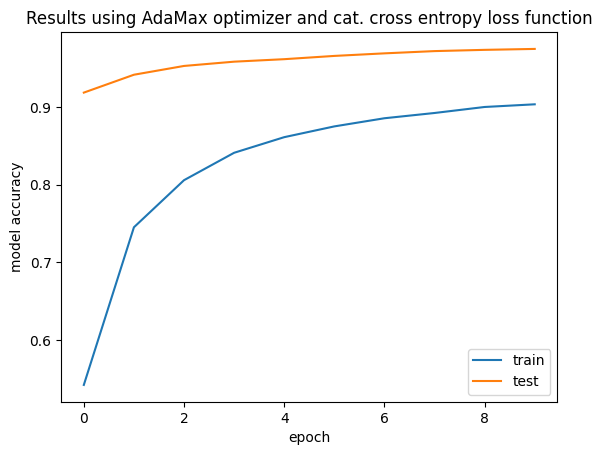

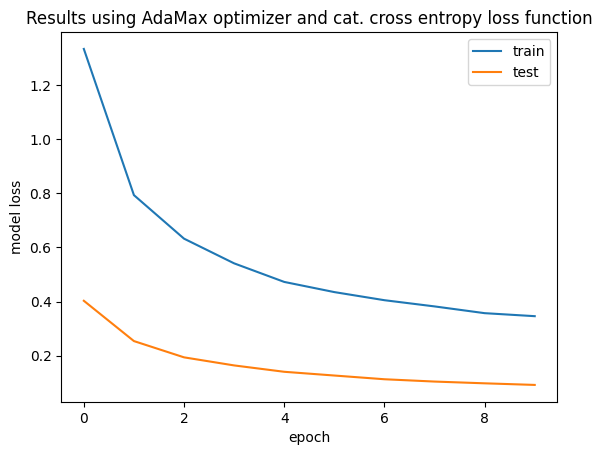

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


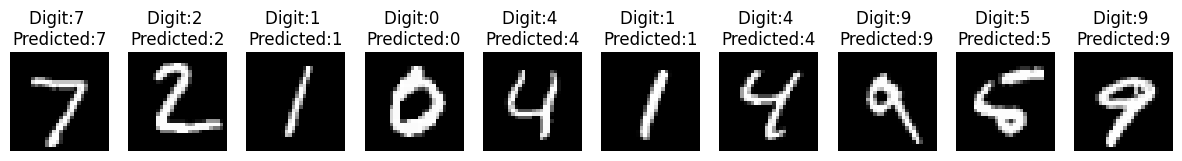

In [2]:
draw_graphs(epochs=10, optimizer='AdaMax', verbose=1, neurons_per_layer=[100,25])

Rispetto alla rete DNN precedente con la metà delle epoche si sono ottenuti un valore di Test loss pari a $0.09179$ e Test accuracy di $0.974500$, contro rispettivamente $0.06200$ e $0.98379$. Si nota dunque che i valori sono leggermente peggiori. Si procede dunque a testare la stessa identica configurazione di layer Dense: $400$ e $100$, sempre con $10$ epoche, per un confronto più lecito.

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - acc: 0.6485 - loss: 1.0424 - val_acc: 0.9528 - val_loss: 0.1567
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - acc: 0.9073 - loss: 0.3128 - val_acc: 0.9671 - val_loss: 0.1029
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - acc: 0.9353 - loss: 0.2296 - val_acc: 0.9745 - val_loss: 0.0809
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - acc: 0.9468 - loss: 0.1864 - val_acc: 0.9780 - val_loss: 0.0699
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - acc: 0.9535 - loss: 0.1620 - val_acc: 0.9807 - val_loss: 0.0623
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - acc: 0.9588 - loss: 0.1467 - val_acc: 0.9832 - val_loss: 0.0565
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - acc: 0.9625 - loss: 0.1339 - val_acc: 0.9841 - val_loss: 0.0523
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - acc: 0.9639 - loss: 0.1244 - val_acc: 0.9853 - val_loss: 0.0488
Epoch 9/10
1875/1875 ━━━

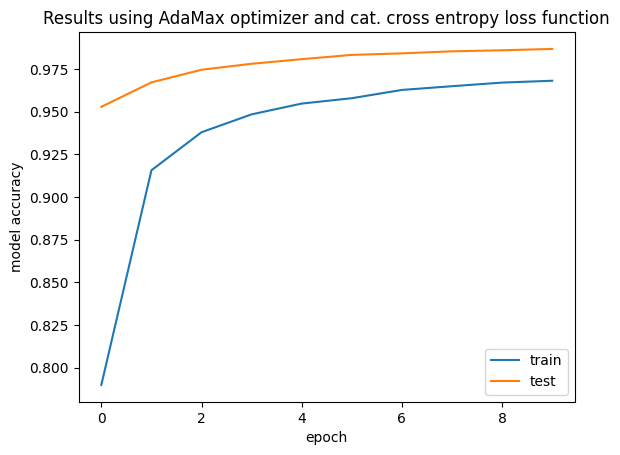

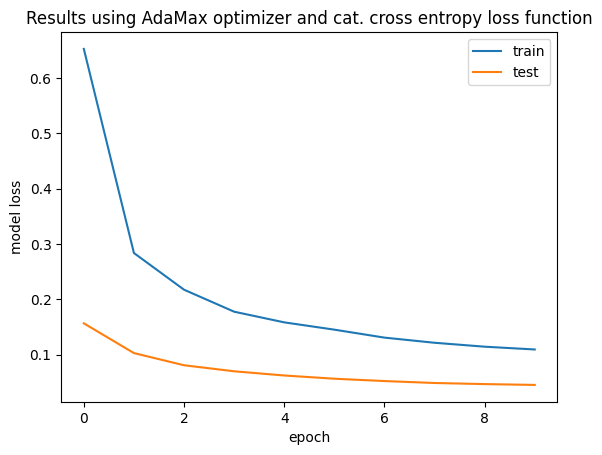

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


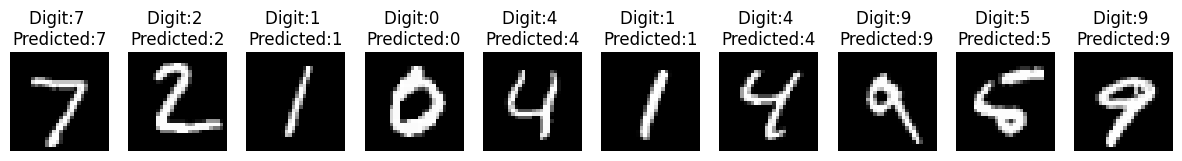

In [3]:
draw_graphs(epochs=10, optimizer='AdaMax', verbose=1, neurons_per_layer=[400,100])

In questo caso il risultato è stato migliore rispetto alla rete iniziale DNN: Test loss pari a $0.04529$ e Test accuracy di $0.98670$, contro rispettivamente $0.06200$ e $0.98379$, ricordando che questo risultato è stato ottenuto per fino con la metà delle epoche! <br>
Sebbene si potrebbero testare molte altre configurazioni, questo risultato conferma che i layer convoluzionali migliorano le reti neurali.

### Esercizio 12.3
In questo ultimo punto si procede a testare la rete creata con $10$ cifre scritte personalmente e caricate da file esterni.

In [7]:
# Ricreo la rete CNN e carico tutte le mie cifre

#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
# Loading data dal database mnist
from keras.datasets import mnist

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.layers import Flatten, Conv2D, MaxPooling2D

from PIL import Image

seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

#########################
# carico le miei immagini
digits_filename = ["./my_digits/"+str(i)+".png" for i in range(10)]
# Carico e converto le immagini in scala di grigi e le ridimensiona a 28x28 pixels
digits_in = [Image.open(f).convert('L').resize((img_rows, img_cols)) for f in digits_filename]
# Inizializzo un array per contenere i dati delle immagini normalizzate
my_data = np.zeros((10, img_rows, img_cols), dtype=np.float32)

for i, digit in enumerate(digits_in):
    data = np.array(digit)
    # Normalizzo i valori a [0, 1]
    my_data[i] = data / 255.0

# Reshape per adattarsi all'input richiesto dalla rete (batch_size, height, width, channels)
my_data = my_data.reshape((10, img_rows, img_cols, 1))

############

# the data, automatic split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
# sono le immagini e i numeri interi che identificano le digits corrette

# questi vettori X_train e X_test contengono la lista di 60000 e 10000 matrici 28x28; 
# X_test[0] contiene una lista di liste, in cui quest'ultima è la RIGA con tutti i numeri da 0 a 255 
# della tonalità di grigio del rispettivo pixel

# In una rete convoluzionale devo lasciare i dati come matrici 2D
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols) # 1 indica che c'è un solo canale di colore
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
# in questo modo creo una lista di liste di 10 elementi con un 1 alla posizione che corrisponde al numero intero vero della cifra
Y_test = keras.utils.to_categorical(Y_test, num_classes)

####################################################################
def create_CNN(optimizer, loss, neurons_per_layer:list):
    "Create a Convolutional Neural Network"
    # instantiate model
    model = Sequential()
    # Nella DCNN prima di un convolutional layer l'input layer 1D con 28x28 nodi non va messo
    # model.add(Input(shape=(img_rows*img_cols,)))
    
    # Aggiungo il primo layer convoluzionale fatto da 10 filtri 5x5 (ovvero analizzano gruppi di pixel 5x5)
    model.add(Conv2D(10, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    # aggiungo un layer che riduce a 14x14 i pixel (prende il massimo tra i 4 pixel presi in considerazione)
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5)) # spegne il 50% dei nodi a caso ad ogni epoca per ridurre overfitting

    # reshape dei dati ad array 1D
    model.add(Flatten())

    # Aggiungo i layers nascosti, se i neuroni per layers inseriti in ingresso sono [0] allora non aggiungo niente
    # devo mettere il controllo altrimenti fa casino
    if neurons_per_layer[0]==0 and len(neurons_per_layer)==1:
        pass
    else:
        for n in neurons_per_layer:
            model.add(Dense(n, activation='relu'))
            # apply dropout with rate 0.5
            model.add(Dropout(0.5)) # spegne il 50% dei nodi a caso ad ogni epoca per ridurre overfitting
            
    # soft-max layer output per normalizzare a 1 la somma delle uscite e renderle ognuna positiva
    model.add(Dense(num_classes, activation='softmax'))

    # compile the model
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['acc']) # scelgo la metrica accuracy per valutare la bontà delle previsioni (quante sono corrette)

    return model


def draw_my_graphs(epochs=10, loss=keras.losses.categorical_crossentropy, optimizer='AdaMax', batch_size=32, verbose=1, neurons_per_layer=[400,100]):
    # create the deep neural net
    model_CNN = create_CNN(optimizer, loss, neurons_per_layer=neurons_per_layer)

    # train DNN and store training info in history
    history = model_CNN.fit(X_train, Y_train, # input e output (quello vero con cui confrontare)
                            batch_size=batch_size, # divisione del dataset di training
                            epochs=epochs,
                            verbose=verbose, # ovvero stampa runtime il progresso dell'addestramento
                            validation_data=(X_test, Y_test))

    # Test del modello addestrato sui dati di validazione
    score = model_CNN.evaluate(X_test, Y_test, verbose=verbose)

    # print performance
    print()
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # look into training history, summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('CNN with ' + optimizer + ' optimizer and ' + loss + ' loss function' if loss != keras.losses.categorical_crossentropy else 'Results using ' + optimizer + ' optimizer and cat. cross entropy loss function')
    plt.ylabel('model accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('CNN with ' + optimizer + ' optimizer and ' + loss + ' loss function' if loss != keras.losses.categorical_crossentropy else 'Results using ' + optimizer + ' optimizer and cat. cross entropy loss function')
    plt.ylabel('model loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()

    predictions = model_CNN.predict(X_test)
    my_predictions = model_CNN.predict(my_data)

    # per disegnare ho bisogno di riconvertire in matrici 28x28
    X_test_reshaped = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1) # lista di 28 liste con dentro 28 numeri (ognuno è una lista da un elemento)
    my_data_reshaped = my_data.reshape(my_data.shape[0], img_rows, img_cols, 1)

    plt.figure(figsize=(15, 15))
    for i in range(10):    
        ax = plt.subplot(2, 10, i + 1)    
        plt.imshow(X_test_reshaped[i, :, :, 0], cmap='gray')    
        plt.title("Digit:{} \nPredicted:{}".format(np.argmax(Y_test[i]), np.argmax(predictions[i]))) # argmax ritorna l'indice del valore massimo in un array
        plt.axis('off') 
    plt.show()

    # salvo le cifre azzeccate
    my_accurancy = 0
    # plotto i miei risultati
    plt.figure(figsize=(15, 15))
    for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(my_data_reshaped[i, :, :, 0], cmap='gray')    
        plt.title("My digit:{} \nPredicted:{}".format(i, np.argmax(my_predictions[i]))) # argmax ritorna l'indice del valore massimo in un array
        plt.axis('off')
        if np.argmax(my_predictions[i]) == i:
            my_accurancy += 1
    plt.show()

    print(f"My accurancy: {my_accurancy/10:.2f}")


c:\Users\teote\Desktop\uni\2023-2024\Lab_Simulazione_Numerica\File_Esercizi\LSN_venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - acc: 0.6664 - loss: 1.0013 - val_acc: 0.9575 - val_loss: 0.1454
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - acc: 0.9144 - loss: 0.2915 - val_acc: 0.9692 - val_loss: 0.0969
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - acc: 0.9361 - loss: 0.2199 - val_acc: 0.9753 - val_loss: 0.0786
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - acc: 0.9471 - loss: 0.1809 - val_acc: 0.9789 - val_loss: 0.0682
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - acc: 0.9539 - loss: 0.1594 - val_acc: 0.9819 - val_loss: 0.0581
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - acc: 0.9561 - loss: 0.1509 - val_acc: 0.9833 - val_loss: 0.0526
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - acc: 0.9630 - loss: 0.1281 - val_acc: 0.9844 - val_loss: 0.0487
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - acc: 0.9639 - loss: 0.1242 - val_acc: 0.9848 - val_loss: 0.0462
Epoch 9/10
1875/1875 ━━━

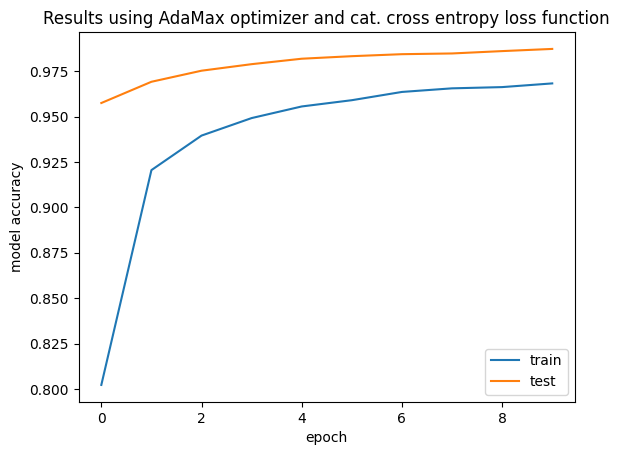

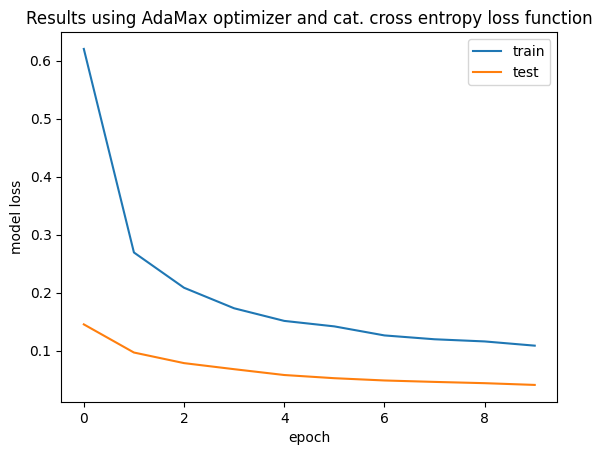

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


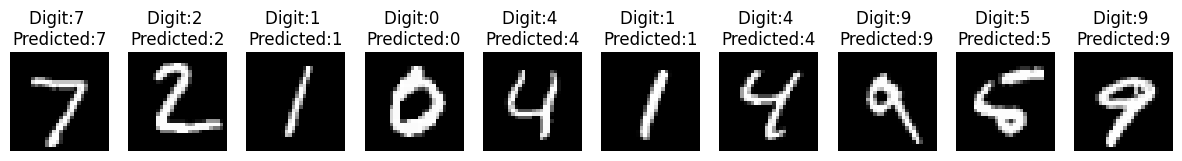

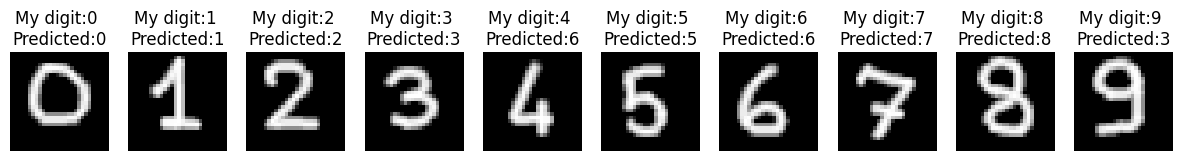

My accurancy: 0.80


In [8]:
draw_my_graphs() # lascio tutti i parametri di default

Dai risultati ottenuti si nota come la rete abbia riconosciuto quasi tutti i numeri, a parte il $4$ e il $9$; per queste cifre si può "scusare" la rete col fatto che disegno le cifre in modo diverso dal solito (il nove con la gamba verso sinitra e non verticale e il quattro senza la doppia "forchetta").